<a href="https://colab.research.google.com/github/bbberylll/ESAA_OB/blob/main/ESAA_OB_M3%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 부스팅

: 약한 학습기 여러개를 연결해서 강한 학습기를 만듦


1. AdaBoost
: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높이는 것
  1) 장점
      * 학습률을 절반으로 낮춘다 == 잘못 분류된 샘플의 가중치가 반복마다 절반 정도 높아진다.
      * 훈련이 끝난 후에는 배깅, 페이스팅 방식으로 예측 진행 + 예측마다 가중치가 다름
  
  2) 단점
      * 각 예측기가 끝나고 다음으로 넘어갈 수 있음 == 병렬화가 불가능 == 확장성이 배깅, 부스팅에 비해 떨어진다.


   
  가중치, 에러율 식 : 아래 사진 참고
  **에러율 r을 계산해서 log 식에 넣고 학습률과 곱하면 가중치가 나오게 된다!**

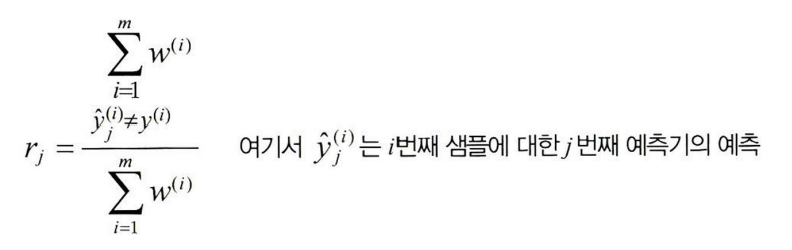

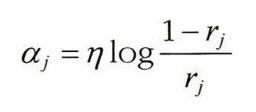

예측기가 정확할 수록 가중치는 높아지게 된다!
random한 예측보다 성능이 좋지 않으면 가중치는 음수가 된다.

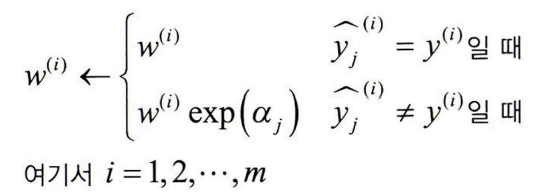

위의 식으로 가중치를 업데이트하고 가중치를 정규화하는 과정을 거치며 반복함


### 코드 구현 방법
1. SAMME - 에이다부스트의 다중 클래스 버전

2. AdaBoostRegressor & AdaBoostClassifier


2. GradientBoost
: 이전 예측기가 만든 잔여 오차 (residual error)에 새로운 예측기를 학습 시킴

- Gradient Tree Boosting = Gradient Boosted Regression Tree

  ## 코드 구현
    1) GradientBoostingRegressor - GBRT 앙상블

    * 앙상블 훈련을 제어 - n_estimator &  결정트리 성장 제어 - max_depth, min_samples_leaf
    
    * learning_rate = 각 트리의 기여도 조절함 (낮을 수록 성능은 좋아지지만 많은 트리가 필요해짐. **그러나 과대적합 될 수 있으니 조기종료 기법을 함께 사용하는게 좋다**

    * subsample=0.25 : 사용할 훈련 샘플의 비율 -- 편향이 높아지지만 분산이 낮아진다. (다양성이 증가하니까) == **확률적 그레이디언트 부스팅**



  2) 최적화된 그레이디언트 부스팅 -- XGBoost



## 스태킹

= 여러 학습기를 훈련시킴 + 마지막 예측기*가 이 예측을 입력으로 받아서 최종 예측을 만듦
* 마지막 예측기 = 블렌더, 메타 학습기

블렌더 학습은 홀드-아웃 세트를 사용함


데이터를 서브셋 2개로 나눔 --
첫번째 서브셋으로 훈련 시킴 -> 이 모델로 두번째 홀드 아웃 세트을 예측

타깃값은 그대로, 위에서 예측한 값이 입력 특성 -- 새로운 훈련 세트 생성 & 블렌더를 이 데이터로 훈련시킴 (3차원이 되는 것)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

## 오차에 두번째 학습기 학습
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)


y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y3)


#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


DecisionTreeRegressor(max_depth=2)

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

## 최적의 트리 갯수를 찾기 위한 코드
- staged_predict를 이용한 방법

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(85))

## 최적의 트리 갯수를 찾으면 학습을 중단하는 방법

In [9]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up=0

for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)

  if val_error < min_val_error:
    min_val_error= val_error
    error_going_up=0

  else:
    error_going_up+=1
    if error_going_up == 5:
      break # 조기종료

In [10]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [14]:
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.38769
[1]	validation_0-rmse:0.29601
[2]	validation_0-rmse:0.23791
[3]	validation_0-rmse:0.20295
[4]	validation_0-rmse:0.18395
[5]	validation_0-rmse:0.17591
[6]	validation_0-rmse:0.17430
[7]	validation_0-rmse:0.17568
[8]	validation_0-rmse:0.17837
